In [1]:
from typing import TypedDict, List, Dict, Any, Literal, Callable, NamedTuple
import json
from pydantic import BaseModel, Field
import random
from langgraph.graph import StateGraph, END
from openai import OpenAI
from sklearn.model_selection import train_test_split
import pandas as pd


In [2]:
from tenacity import retry, stop_after_attempt, wait_exponential

client = OpenAI()

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=2, max=10))
def llm_call(system_prompt: str, prompt: str, OutputFormat: BaseModel, model: str = "gpt-3.5-turbo-instruct-0914"):
    llm_out = client.responses.parse(
        model=model,
        input=[{"role": "system", "content": system_prompt},
               {"role": "user", "content": prompt}],
        text_format=OutputFormat,
    )
    llm_out = llm_out.output_parsed
    return llm_out

In [18]:
# Configuration
MAX_ITERATIONS = 10
TARGET_SCORE = 0.9

# State definition
class PromptEngineerState(TypedDict):
    current_prompt: str
    evaluation_dataset: List[Dict[str, Any]]
    performance_metrics_string: str
    performance_metrics: Dict[str, float]
    failure_analysis: List[Dict[str, Any]]
    improvement_actions: List[str]
    iteration_count: int
    best_prompt: str
    best_score: float
    search_history: List[Dict[str, Any]]
    selected_action: str
    epsilon_choice: str  # "explore" or "exploit"

# Available improvement actions
IMPROVEMENT_ACTIONS = [
    "Add/remove examples: This is pertaining to few-shot prompting. Try not to add examples directly from the feedback. Instead, create new examples that are similar in nature to the feedback.",
    "Add/remove Chain of Thought reasoning: You can ask the model to think step-by-step, and output its reasoning. This may or may not improve the performance. You should consider removing it if it degrades the performance.", 
    "Add/remove specificity: A prompt or any aspect of a prompt can be more or less specific.",
    "Add/remove context: Context can be added or removed to provide more or less information to the model.",
    "Add/remove breaking the problem into subtasks: Consider breaking a complex problem into smaller, manageable subtasks, or consolidating subtasks into a single task if appropriate.",
    "Add/remove role definitions: Clearly specify the role the model should assume when generating a response.",
    "Add/remove constraints: Introduce constraints to guide the model's responses more effectively.",
    "Add/remove asking for alternatives: Encourage the model to explore alternative solutions or perspectives.",
    "Add/remove including negative examples: Provide examples of undesirable responses to help the model learn from mistakes.",
    "Add/remove verification steps: Include steps for the model to verify its own answers.",
    "Add/remove specifying thinking style: Instruct the model on the preferred style of reasoning or explanation.",
    "Add/remove including edge cases: Encourage the model to consider edge cases in its responses.",
    "Add/remove quality criteria: Specify the criteria that the model's responses should meet.",
    "Add/remove requesting explanations: Ask the model to explain its reasoning or thought process.",
    "Other: This is a catch-all for any other improvement action that may not fit the above categories.",
]

##############################################
# Epsilon-greedy strategy for prompt selection
##############################################

class PromptTemplateData(NamedTuple):
    prompt: str
    system_prompt: str
    prompt_format_function: Callable[[str], str] = lambda x: x
    output_format: BaseModel = None

class PromptOptimizer:
    def __init__(
        self,
        #failure_analysis: PromptTemplateData,
        action_selection: PromptTemplateData,
        action_application: PromptTemplateData,
        initial_prompt: PromptTemplateData,
        evaluation_method: Callable[[PromptTemplateData, List[Any]], Dict[str, float]],
        training_dataset: List[Any],
        action_list: List[str] = IMPROVEMENT_ACTIONS,
        train_test_ratio: float = 0.5,
        epsilon: float = 0.3,  # exploration rate
        epsilon_decay: float = 0.95,  # decay rate for epsilon
        min_epsilon: float = 0.1,  # minimum exploration rate
    ):
        #self.failure_analysis = failure_analysis
        self.action_selection = action_selection
        self.action_application = action_application
        self.action_list = action_list
        self.initial_prompt = initial_prompt
        self.evaluation_method = evaluation_method
        self.training_dataset, self.evaluation_dataset = train_test_split(
            training_dataset, test_size=1 - train_test_ratio, random_state=42
        )

        # Epsilon-greedy parameters
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Build the workflow
        self.workflow = StateGraph(PromptEngineerState)
        self.workflow.add_node("evaluate", self.evaluate_prompt_node)
        #self.workflow.add_node("analyze_failures", self.analyze_failures_node)
        self.workflow.add_node("epsilon_greedy_choice", self.epsilon_greedy_choice_node)
        self.workflow.add_node("select_action", self.select_action_node)
        self.workflow.add_node("apply_action", self.apply_action_node)

        #self.workflow.add_edge("evaluate", "analyze_failures")
        self.workflow.add_edge("evaluate", "epsilon_greedy_choice")
        self.workflow.add_edge("epsilon_greedy_choice", "select_action")
        self.workflow.add_edge("select_action", "apply_action")
        self.workflow.add_conditional_edges("apply_action", self.should_continue)
        self.workflow.set_entry_point("evaluate")
        self.app = self.workflow.compile()

    def evaluate_prompt_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print(f"🔍 Evaluating prompt (iteration {state['iteration_count']})")
        
        # Generate metrics
        metrics = self.evaluation_method(state["current_prompt"], self.training_dataset)
        validation_metrics = self.evaluation_method(state["current_prompt"], self.evaluation_dataset)
        accuracy = metrics.get("accuracy", 0)
        recall = metrics.get("recall", 0)
        precision = metrics.get("precision", 0)
        false_positive_rate = metrics.get("false_positive_rate", 0)
        # Calculate F1 score
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        # calculate f1 score for validation dataset
        if validation_metrics.get("precision", 0) + validation_metrics.get("recall", 0) > 0:
            validation_f1_score = 2 * (validation_metrics.get("precision", 0) * validation_metrics.get("recall", 0)) / (validation_metrics.get("precision", 0) + validation_metrics.get("recall", 0))
        else:
            validation_f1_score = 0
        # Extract failure cases
        if "failure_cases" in metrics:  # Ensure failure_cases is in metrics
            failure_cases = metrics["failure_cases"]
        else:
            failure_cases = []
        metrics = {
            "validation_accuracy": validation_metrics.get("accuracy", 0),
            "validation_recall": validation_metrics.get("recall", 0),
            "validation_precision": validation_metrics.get("precision", 0),
            "validation_f1_score": validation_f1_score,
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "f1_score": f1_score,
            "false_positive_rate": false_positive_rate,
            "failure_cases": "\n".join(failure_cases) if failure_cases else "None" # convert list to string to feed to the llm
        }
        
        # Track best prompt globally
        new_best_prompt = state["best_prompt"]
        new_best_score = state["best_score"]
        
        if f1_score > state["best_score"]:
            new_best_prompt = state["current_prompt"]
            new_best_score = f1_score
            print(f"🎉 New best score: {f1_score:.3f}")

        #performance_metrics_string = ''
        #for item in metrics:
        #    performance_metrics_string += f"{item}:\n {metrics[item]}\n"
        
        performance_metrics_string = ''
        for item in metrics:
            performance_metrics_string += f"{item}:\n {metrics[item]}\n"
        
        return {
            **state,
            "performance_metrics_string": performance_metrics_string,
            "performance_metrics": metrics,
            "best_prompt": new_best_prompt,
            "best_score": new_best_score
        }

    def epsilon_greedy_choice_node(self, state: PromptEngineerState) -> PromptEngineerState:
        """Epsilon-greedy choice: continue current prompt with prob epsilon, or use best prompt with prob 1-epsilon"""
        current_epsilon = max(self.min_epsilon, self.epsilon * (self.epsilon_decay ** state["iteration_count"])) # Decay epsilon via a power function
        
        if random.random() < current_epsilon:
            # Explore: continue with current prompt (go to action selection)
            print(f"🔍 Exploring - continuing with current prompt (ε={current_epsilon:.3f})")
            choice = "explore"
        else:
            # Exploit: use best known prompt (skip to next iteration)
            print(f"💰 Exploiting - using best known prompt (ε={current_epsilon:.3f})")
            choice = "exploit"
            # Set current prompt to best prompt
            state = {
                **state,
                "current_prompt": state["best_prompt"] if state["best_prompt"] else state["current_prompt"]
            }
        
        return {
            **state,
            "epsilon_choice": choice
        }

    def select_action_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print("🤖 Selecting improvement action")
        
        metrics = state["performance_metrics"]
        
        # LLM based action selection
        random.shuffle(self.action_list) # We shuffle to debias the llm's potential location bias
        llm_action_output = llm_call(
            system_prompt=self.action_selection.system_prompt,
            prompt= self.action_selection.prompt_format_function(
            prompt = self.action_selection.prompt,
            current_prompt=state["current_prompt"],
            performance_metrics=json.dumps({k: v for k, v in metrics.items() if not k.startswith("validation_")}, indent=2),
            improvement_actions=", ".join(self.action_list),
            ),
            OutputFormat=self.action_selection.output_format,
        )

        selected_action = llm_action_output.get("action", None)
        assert selected_action is not None, "LLM did not return a valid action. Please check the action selection prompt and the LLM response format."
        
        print(f"🎯 Selected action: {selected_action}")
        return {
            **state,
            "selected_action": selected_action
        }

    def apply_action_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print(f"⚡ Applying action: {state['selected_action']}")
        action = state["selected_action"]
        current_prompt = state["current_prompt"]
        
        # Apply the selected action to modify the prompt
        llm_new_prompt_output = llm_call(
            system_prompt=self.action_application.system_prompt,
            prompt=self.action_application.prompt_format_function(
                prompt=self.action_application.prompt,
                selected_action=action,
                current_prompt=current_prompt,
                performance_metrics=json.dumps({k: v for k, v in metrics.items() if not k.startswith("validation_")}, indent=2),
            ),
            OutputFormat=self.action_application.output_format,
        )

        new_prompt = llm_new_prompt_output.get("new_prompt", current_prompt)
        assert new_prompt is not None, "LLM did not return a valid new prompt. Please check the action application prompt and the LLM response format."

        new_history = state["search_history"] + [{
            "iteration": state["iteration_count"],
            "action": action,
            "prompt": new_prompt,
            "metrics": state["performance_metrics"], 
        }]

        print(f"iteration: {state['iteration_count']} | action: {action} | training f1_score: {state['performance_metrics']['f1_score']:.3f} | validation f1_score: {state['performance_metrics']['validation_f1_score']:.3f}")
        
        return {
            **state,
            "current_prompt": new_prompt,
            "iteration_count": state["iteration_count"] + 1,
            "search_history": new_history
        }

    def should_continue(self, state: PromptEngineerState) -> Literal["evaluate", "__end__"]:
        if state["iteration_count"] >= MAX_ITERATIONS:
            print(f"🛑 Max iterations ({MAX_ITERATIONS}) reached")
            return "__end__"
        if state["performance_metrics"]["f1_score"] >= TARGET_SCORE:
            print(f"🎯 Target score ({TARGET_SCORE}) achieved!")
            return "__end__"
        return "evaluate"

    def visualize(self):
        try:
            from IPython.display import Image, display
            display(Image(self.app.get_graph().draw_mermaid_png()))
        except ImportError:
            print("To visualize the graph, install: pip install grandalf")
            print("Or use: app.get_graph().print_ascii()")
            print("\nWorkflow Graph (ASCII):")
            self.app.get_graph().print_ascii()
    
    def run(self) -> PromptEngineerState:
        initial_state: PromptEngineerState = {
            "current_prompt": self.initial_prompt,
            "evaluation_dataset": self.evaluation_dataset,
            "performance_metrics_string": "",
            "performance_metrics": {},
            "failure_analysis": [],
            "improvement_actions": [],
            "iteration_count": 0,
            "best_prompt": self.initial_prompt,
            "best_score": 0.0,
            "search_history": [],
            "selected_action": "",
            "epsilon_choice": ""
        }
        final_state = self.app.invoke(initial_state)
        return final_state

In [23]:
from tqdm import notebook
training_dataset = pd.read_csv("Train.csv").sample(200, random_state=42)

def evaluation_method(prompt: PromptTemplateData, dataset: pd.DataFrame) -> Dict[str, float]:
    # evaluation method for demonstration
    prediction = []
    for index, row in notebook.tqdm(dataset.iterrows(), total=len(dataset)):
        system_prompt = prompt.system_prompt
        formatted_prompt = prompt.prompt_format_function(prompt.prompt, row['text'])
        OutputFormat = prompt.output_format
        llm_response = llm_call(system_prompt=system_prompt, prompt=formatted_prompt, OutputFormat=OutputFormat, model="gpt-4o")
        prediction.append(1 if llm_response.sentiment else 0)
    actual = dataset['label'].to_list()
    precision = sum(p == a == 1 for p, a in zip(prediction, actual)) / sum(p == 1 for p in prediction) if sum(p == 1 for p in prediction) > 0 else 0
    recall = sum(p == a == 1 for p, a in zip(prediction, actual)) / sum(a == 1 for a in actual) if sum(a == 1 for a in actual) > 0 else 0
    return {
        "accuracy": sum(p == a for p, a in zip(prediction, actual)) / len(actual),
        "recall": recall,
        "precision": precision,
        "f1_score": 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0,
        "false_positive_rate": sum(p == 1 and a == 0 for p, a in zip(prediction, actual)) / sum(a == 0 for a in actual) if sum(a == 0 for a in actual) > 0 else 0,
        "failure_cases": [row + f" predicted: {prediction[i]}" + f" actual: {row['label']}" for i, (index, row) in enumerate(dataset.iterrows()) if row['label'] != prediction[i]]
    }

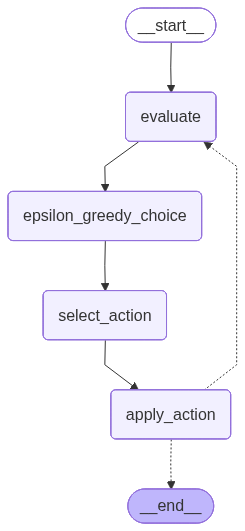

In [24]:
# Define the output formats for LLM nodes
class ActionOutputFormat(BaseModel):
    """Output format for the action selection step."""
    cot: str = Field(..., description="Chain of thought reasoning for the selected action.")
    action: str = Field(..., description="The selected action to apply to the current prompt.")

class ActionApplicationOutputFormat(BaseModel):
    """Output format for the action application step."""
    cot: str = Field(..., description="Chain of thought reasoning for the action application.")
    new_prompt: str = Field(..., description="The new prompt after applying the selected action.")

class InitialPromptOutputFormat(BaseModel):
    """Output format for the initial prompt."""
    sentiment: bool = Field(..., description="sentiment analysis of the text either positive/True or negarive/False")
    other: str = Field(..., description="Everything else requested by the prompt in string format.")

initial_prompt=PromptTemplateData(
    prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
    system_prompt="You are an expert in extracting the comment sentiment from the given text.",
    output_format=InitialPromptOutputFormat,
    prompt_format_function=lambda x, y: x.format(text=y)
)

# Initialize the PromptOptimizer with the initial prompt and evaluation method
po = PromptOptimizer(
    evaluation_method=evaluation_method,     # evaluation method for demonstration
    training_dataset=training_dataset,
    action_selection=PromptTemplateData(
        prompt="Select an improvement action based on failure analysis: \nCurrent Prompt: {current_prompt}\nPerformance Metrics: {performance_metrics}\nImprovement Actions: {improvement_actions}",
        system_prompt="""You are an expert prompt engineer. Your task is to optimize prompts for a given task.
        You will be provided with a current prompt, a dataset for evaluation, and a set of improvement actions.
        Your goal is to iteratively improve the prompt based on performance metrics and failure analysis.
        You will select an action to apply to the current prompt, and then apply that action to generate a new prompt.
        The process will continue until the performance metrics meet the target score or the maximum number of iterations is reached.
        """,
        output_format=ActionOutputFormat,
        prompt_format_function=lambda x, y: x.format(**y)
    ),
    action_application=PromptTemplateData(
        prompt="Apply the selected action to the current prompt:\n {selected_action} \nCurrent Prompt: {current_prompt}\nPerformance Metrics: {performance_metrics}",
        system_prompt="""Your task is to improve a prompt based on the selection action and performance metrics.
        You should provide the new prompt that results from applying the action to the current prompt. Make sure the new prompt is clear, concise, and effectively incorporates the selected improvement action.
        Do not change any other aspect of the prompt except for the selected action.""",
        prompt_format_function=lambda x, y: x.format(**y)
    ),
    initial_prompt=PromptTemplateData(
        prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
        system_prompt="You are an expert in extracting the comment sentiment from the given text.",
        output_format=InitialPromptOutputFormat,
        prompt_format_function=lambda x, y: x.format(text=y)
    ),
    action_list=IMPROVEMENT_ACTIONS,
    train_test_ratio=0.8,
)

po.visualize()

In [25]:

final_state = po.run()

🔍 Evaluating prompt (iteration 0)


  0%|          | 0/160 [00:00<?, ?it/s]

KeyboardInterrupt: 